
# Model


In [1]:
# Import Libraries and Dependencies

import findspark
findspark.init()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve, auc, r2_score
from keras.regularizers import l1_l2


In [2]:
# Initialise Spark Session for large-scale data processing
spark = SparkSession.builder.appName("LSTMModel").getOrCreate()


In [3]:
# Read data using Spark
df_spark = spark.read.csv('Data/F6_Transformed_Data.csv', header=True, inferSchema=True)
# Preprocessing and transformation steps performed in the Data_Analysis.ipynb


In [4]:
# Convert Spark DataFrame to Pandas DataFrame for easier manipulation
data = df_spark.toPandas()

In [5]:
# Data Preprocessing
# Extracting the year from the date and filtering data based on specific years
data['Year'] = pd.to_datetime(data['Date']).dt.year

filtered_data = data[data['Year'].isin([2020, 2021, 2022, 2023, 2024, 2025])]


In [6]:
# # Feature Scaling - Normalising features to aid in model training
# # Creating an instance of label encoder
# label_encoder = LabelEncoder()

# # Assuming 'Criteria' is a categorical column that needs to be converted
# filtered_data['Criteria'] = label_encoder.fit_transform(filtered_data['Criteria'])

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data
scaled_data = scaler.fit_transform(filtered_data[['Degree', 'Length', 'Thickness', 'Thickness_Difference', 'Original Thickness', 'Year']])
#scaled_data = scaler.fit_transform(filtered_data[['Degree', 'Length', 'Thickness', 'Thickness_Difference', 'Original Thickness', 'Year', 'Criteria']])


##### Function for time series forecasting tasks, to create input-output pairs for training a model. A look_back parameter controls how much historical data the model uses to make predictions, allowing for experimenting with different levels of temporal context to make predictions based on the dynamics of data over time.

In [7]:
# Function to create a dataset suitable for LSTM training
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # Modify to select the appropriate target variable
    return np.array(X), np.array(Y)

##### Organizing time series data into sequences of a fixed length (look_back) to train an LSTM model for tasks like time series forecasting or sequence prediction, allowing the model to learn patterns and relationships in the data over a specific time window.

In [8]:
# Preparing data for LSTM model
look_back = 3
X, y = create_dataset(scaled_data, look_back)

##### Binary classification by defining a threshold for target variables and splitting the dataset into training and testing sets.
##### Set a threshold value of 0.75. This threshold is used to convert regression problem into a binary classification problem, any target value (y) less than 0.75 will be classified as 1, and any value greater than or equal to 0.75 will be classified as 0.

###### The test_size parameter specifies the proportion of the data to be used for testing (in this case, 20%), and random_state ensures reproducibility by seeding the random number generator.

###### X_train and y_train_binary for training the binary classification model, and X_test and y_test_binary are for evaluating performance on unseen data.

In [9]:
# Defining a threshold for classification
THRESHOLD = 0.75
y_binary = np.where(y < THRESHOLD, 1, 0)
# y_train_binary = (y_train > THRESHOLD).astype(int)
# y_test_binary = (y_test > THRESHOLD).astype(int)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)


###### Reshaping data for LSTM input, reshaping is necessary because LSTM models in Keras expect input data to be in the shape (samples, time_steps, features). This ensures that both the training and testing data have the appropriate shape before feeding them into the LSTM model.

In [10]:
# Reshaping data for LSTM input
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X.shape[2]))


In [11]:

# # # LSTM Model Optimisation in Notepad


In [13]:
# LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

###### Creating an instance of the Adam optimizer with a learning rate of 0.0005. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. 
###### Then compiling the model with the previously defined Adam optimizer. 

In [14]:
# Compiling the model for binary classification
adam_optimizer = Adam(learning_rate=0.0005)  # Adjust learning rate for optimisation
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


##### Using EarlyStopping to monitor the validation loss (val_loss). The patience parameter is set to 10, which means the training will stop if the validation loss does not improve for 10 consecutive epochs. 

In [15]:
# Early stopping to prevent overfitting and checkpointing to save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Set up a model checkpoint that saves the model to the file
checkpoint_loss = ModelCheckpoint('best_model_val_loss.h5', monitor='val_loss', save_best_only=True)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# checkpoint_acc = ModelCheckpoint('best_model_accuracy.h5', monitor='accuracy', save_best_only=True)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='accuracy', save_best_only=True)


In [16]:
# Model Training with Early Stopping and Checkpointing
history = model.fit(X_train, y_train_binary, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint_loss])
# history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint_loss])


Epoch 1/100


2160/2160 [==============================] - 33s 12ms/step - loss: 0.0117 - accuracy: 0.9982 - val_loss: 8.2071e-04 - val_accuracy: 0.9999
Epoch 2/100
   6/2160 [..............................] - ETA: 22s - loss: 6.0263e-06 - accuracy: 1.0000

C:\Users\unsto\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2160/2160 [==============================] - 23s 11ms/step - loss: 7.5867e-04 - accuracy: 0.9999 - val_loss: 7.3886e-04 - val_accuracy: 0.9999
Epoch 3/100
2160/2160 [==============================] - 22s 10ms/step - loss: 4.8491e-04 - accuracy: 0.9999 - val_loss: 8.1469e-04 - val_accuracy: 0.9999
Epoch 4/100
2160/2160 [==============================] - 22s 10ms/step - loss: 9.9711e-06 - accuracy: 1.0000 - val_loss: 9.8688e-04 - val_accuracy: 0.9999
Epoch 5/100
2160/2160 [==============================] - 22s 10ms/step - loss: 9.1669e-04 - accuracy: 0.9999 - val_loss: 7.6863e-04 - val_accuracy: 0.9999
Epoch 6/100
2160/2160 [==============================] - 23s 11ms/step - loss: 8.4138e-06 - accuracy: 1.0000 - val_loss: 9.1780e-04 - val_accuracy: 0.9999
Epoch 7/100
2160/2160 [==============================] - 23s 11ms/step - loss: 1.4717e-06 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9999
Epoch 8/100
2160/2160 [==============================] - 24s 11ms/step - loss: 3.7607e

# Model Evaluation

# Testing LSTM model on a sampled dataset

In [17]:
# Load the Sampled Dataset
# Read data using Spark
sampled_df_spark = spark.read.csv('Data/Sampled_F6_Transformed_Data.csv', header=True, inferSchema=True)
# Preprocessing and transformation steps performed in the Data_Analysis.ipynb


In [18]:
# Sampled Dataset
# Convert Spark DataFrame to Pandas DataFrame for easier manipulation
sampled_data = sampled_df_spark.toPandas()


In [19]:
# Sampled Dataset
# Data Preprocessing
# Extracting the year from the date and filtering data based on specific years
sampled_data['Year'] = pd.to_datetime(sampled_data['Date']).dt.year

sampled_filtered_data = sampled_data[sampled_data['Year'].isin([2020, 2021, 2022, 2023, 2024, 2025])]


In [20]:
# Sampled Dataset
# # Feature Scaling - Normalising features to aid in model training
# # Creating an instance of label encoder
# label_encoder = LabelEncoder()

# # Assuming 'Criteria' is a categorical column that needs to be converted
# sampled_data['Criteria'] = label_encoder.fit_transform(sampled_data['Criteria'])

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data
scaled_sampled_data = scaler.fit_transform(sampled_filtered_data[['Degree', 'Length', 'Thickness', 'Thickness_Difference', 'Original Thickness', 'Year']])


In [21]:
# Sampled Dataset
# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, -1])
    return np.array(X), np.array(Y)

In [22]:
# Sampled Dataset
# Prepare the data for testing
look_back = 3  # Ensure same as used in model training
X_sampled, y_sampled = create_dataset(scaled_sampled_data, look_back)


In [23]:
# Sampled Dataset
# Reshape Data for LSTM
X_sampled = X_sampled.reshape((X_sampled.shape[0], X_sampled.shape[1], X_sampled.shape[2]))


In [24]:
# Sampled Dataset
# Binary Conversion for Testing
THRESHOLD = 0.75  # The threshold used during training
y_sampled_binary = (y_sampled > THRESHOLD).astype(int)


In [25]:
# Sampled Dataset
# Evaluate Model on Sampled Data
# Load the trained model
best_model_val_loss = load_model('best_model_val_loss.h5')
# model = load_model('best_model_val_loss.h5')

# Predictions
sampled_predictions = best_model_val_loss.predict(X_sampled)
sampled_predictions_binary = (sampled_predictions > 0.5).astype(int)

# Evaluation Metrics
sampled_accuracy = accuracy_score(y_sampled_binary, sampled_predictions_binary)
print(f'Sampled Dataset Accuracy: {sampled_accuracy}')

# R-squared Value
sampled_r_squared = r2_score(y_sampled_binary, sampled_predictions_binary)
print(f'Sampled Dataset R-squared: {sampled_r_squared}')

# Confusion Matrix
cm = confusion_matrix(y_sampled_binary, sampled_predictions_binary)
print("Confusion Matrix:\n", cm)


169/169 [==============================] - 2s 4ms/step
Sampled Dataset Accuracy: 0.37787249814677537
Sampled Dataset R-squared: -1.8281703968116059
Confusion Matrix:
 [[ 538 3095]
 [ 262 1501]]


# End of Sampled Dataset

In [26]:
# Load the best model saved by checkpoint
best_model_val_loss = load_model('best_model_val_loss.h5')
# best_model = load_model('best_model.keras')


In [27]:
# Make predictions with the trained model
train_predictions = best_model_val_loss.predict(X_train)
test_predictions = best_model_val_loss.predict(X_test)


675/675 [==============================] - 3s 4ms/step


In [28]:
# Model Evaluation
train_accuracy = accuracy_score(y_train_binary, np.round(train_predictions))
test_accuracy = accuracy_score(y_test_binary, np.round(test_predictions))
print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')


Train Accuracy: 0.9999768507801287
Test Accuracy: 0.9999537037037037


In [29]:
# Calculate and print the R-squared value 
r_squared = r2_score(y_test_binary, test_predictions)
# r_squared = r2_score(y_test_binary, test_predictions_binary)
print(f'R-squared: {r_squared}')


R-squared: 0.999793189772141


In [30]:
# Evaluate the model
loss, accuracy = best_model_val_loss.evaluate(X_test, y_test_binary, verbose=0)
# loss, accuracy = best_model_val_loss.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Test Loss: 0.00022499718761537224, Test Accuracy: 0.9999536871910095


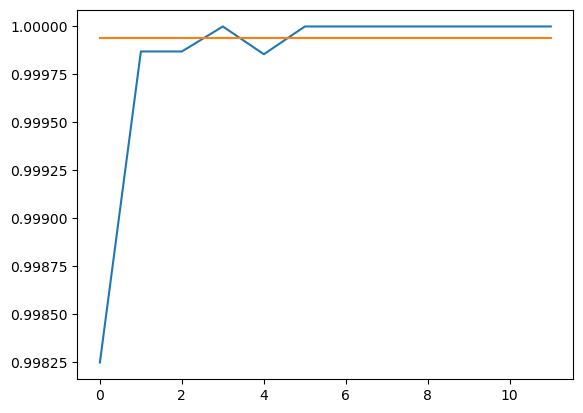

In [31]:
# Visualize training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# # Prediction and Analysis

In [32]:
# Make predictions with the best model
predictions = best_model_val_loss.predict(X_test)

675/675 [==============================] - 3s 4ms/step


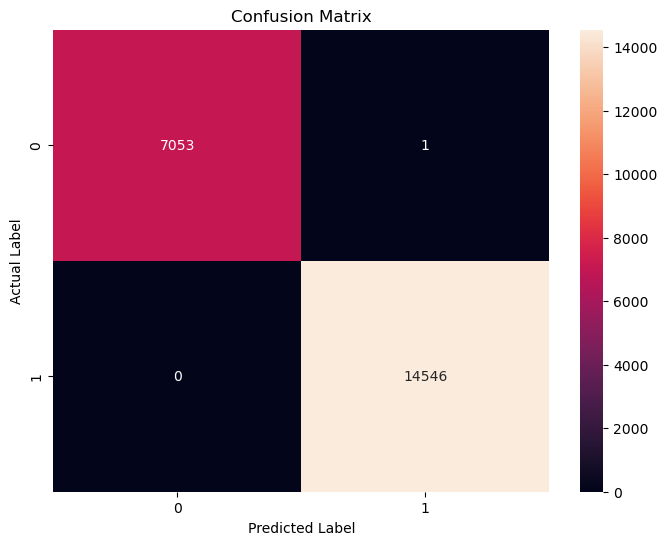

In [33]:
# Confusion matrix
# Convert predictions to binary
binary_predictions = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test_binary, binary_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# plt.savefig('Visualisations/F6_Transformed_Data_Confusion_Matrix.png')
plt.show()


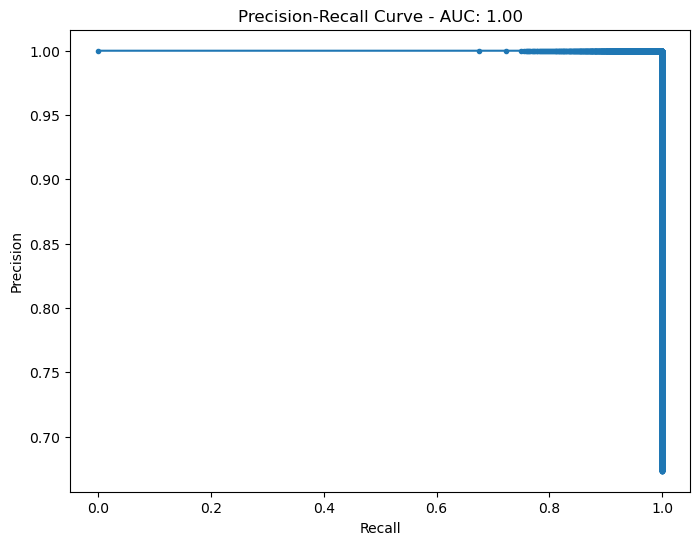

In [34]:
# Precision-recall curve
# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test_binary, predictions)
# precision, recall, thresholds = precision_recall_curve(y_test_binary, test_predictions.ravel())

# Compute the area under the curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve - AUC: {:.2f}'.format(auc_score))
# plt.title(f'Precision-Recall Curve - AUC: {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')

# plt.savefig('Visualisations/F6_Transformed_Data_Precision-Recall_Curve.png')
plt.show()


675/675 [==============================] - 3s 4ms/step


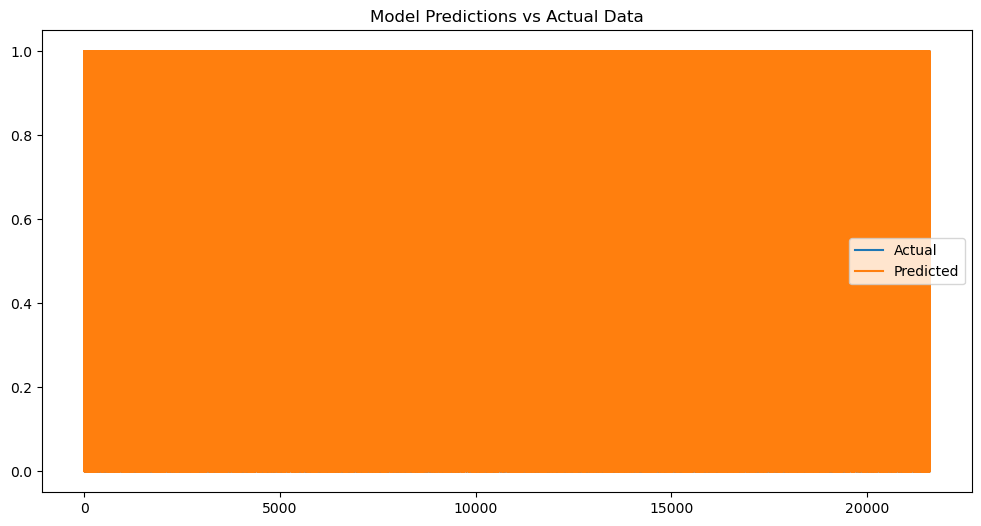

In [35]:
# Visualising model predictions
predictions = best_model_val_loss.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test_binary, label='Actual')  # Corrected variable name
plt.plot(predictions.ravel(), label='Predicted')  # Flatten predictions for plotting
plt.title('Model Predictions vs Actual Data')
plt.legend()

# plt.savefig('Visualisations/F6_Transformed_Data_Model_Predictions_vs_Actual_Data.png')
plt.show()


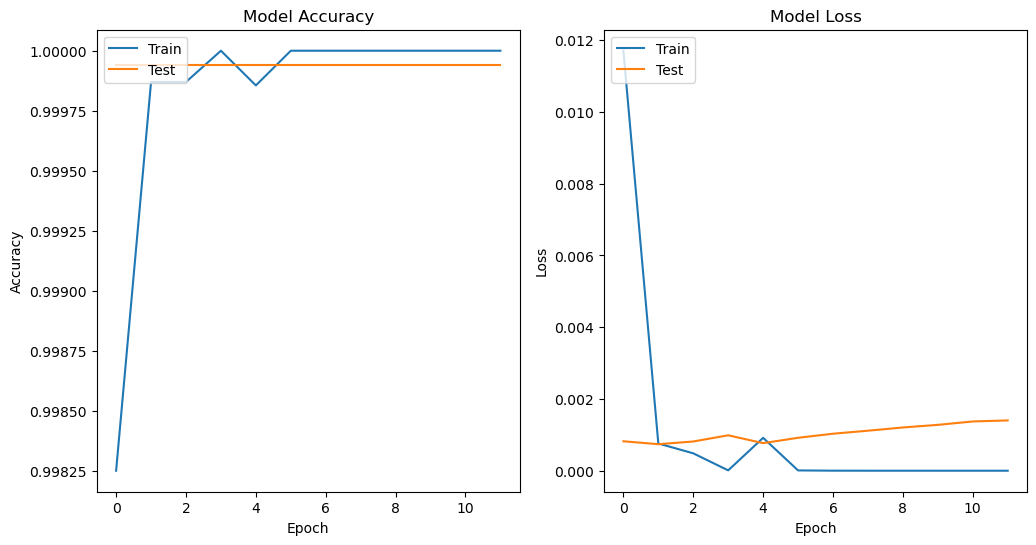

In [36]:
# Training History Visualisation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plt.savefig('Visualisations/F6_Transformed_Data_Training_History_Visualisation.png')
plt.show()


In [37]:
# Stop the Spark Session
spark.stop()
